In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from google.colab import drive
drive.mount('/content/drive')

base_path = '/content/drive/MyDrive/dataset_autoscaling/'
df = pd.read_parquet(os.path.join(base_path, 'nasa_logs_processed.parquet'))

Mounted at /content/drive


In [ ]:
# Tạo hàm gom dữ liệu
def resample_data(df, window):
    # Gom nhóm theo thời gian và tính toán các chỉ số
    resampled = df.resample(window).agg({
        'host': 'count',   # Số lượng request (Hits)
        'bytes': 'sum',    # Tổng dung lượng
        'status': lambda x: (x >= 400).sum() # Số lượng lỗi (để tính Error Rate)
    })
    resampled.columns = ['requests', 'total_bytes', 'errors']

    # Xử lý khoảng trống do Bão (01/08 - 03/08) bằng cách điền số 0
    resampled = resampled.fillna(0)
    return resampled

df_1m = resample_data(df, '1min')
df_5m = resample_data(df, '5min')
df_15m = resample_data(df, '15min')

In [ ]:
split_date = '1995-08-23 00:00:00'

train = df_5m[df_5m.index < split_date]
test = df_5m[df_5m.index >= split_date]

print(f"Dữ liệu huấn luyện: {train.shape}")
print(f"Dữ liệu kiểm thử: {test.shape}")

Dữ liệu huấn luyện: (15264, 3)
Dữ liệu kiểm thử: (2592, 3)


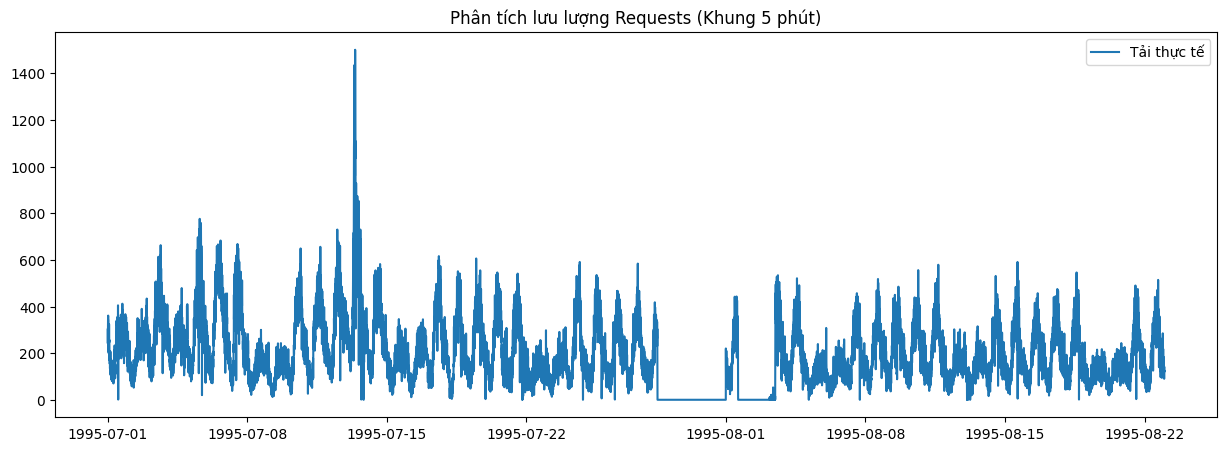

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(train['requests'], label='Tải thực tế')
plt.title('Phân tích lưu lượng Requests (Khung 5 phút)')
plt.legend()
plt.show()

In [ ]:
# --- HÀM TẠO ĐẶC TRƯNG (ĐÃ FIX LỖI LEAKAGE) ---
def enhance_features(df):
    df = df.copy()

    # --- 1. NHÓM CƠ BẢN ---
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['is_weekend'] = df.index.dayofweek.isin([5, 6]).astype(int)

    # --- 2. NHÓM TIME BINS (MỚI) ---
    # Chia buổi: 0-6: Đêm(0), 6-12: Sáng(1), 12-18: Chiều(2), 18-24: Tối(3)
    # pd.cut giúp chia khoảng số thành các nhóm
    df['part_of_day'] = pd.cut(df['hour'],
                               bins=[-1, 5, 11, 17, 23],
                               labels=[0, 1, 2, 3]).astype(int)

    # --- 3. NHÓM CHU KỲ SIN/COS (MỚI - Giúp nối liền 23h và 0h) ---
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

    # --- 4. LAG FEATURES (Giữ nguyên) ---
    for i in range(1, 4):
        df[f'lag_{i}'] = df['requests'].shift(i)

    # --- 5. ROLLING STATS (MỞ RỘNG) ---
    # Quan trọng: Vẫn phải shift(1) để chống Leakage
    window_size = 3
    df_shifted = df['requests'].shift(1)

    df['rolling_mean'] = df_shifted.rolling(window=window_size).mean()
    df['rolling_std'] = df_shifted.rolling(window=window_size).std() # Độ biến động
    df['rolling_max'] = df_shifted.rolling(window=window_size).max() # Đỉnh cao nhất gần đây

    return df.dropna()
train_final = enhance_features(train)
test_final = enhance_features(test)

In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Chuẩn bị dữ liệu
features = ['hour', 'dayofweek', 'is_weekend','part_of_day','hour_sin','hour_cos', 'lag_1', 'lag_2', 'lag_3', 'rolling_mean','rolling_std','rolling_max']
X_train, y_train = train_final[features], train_final['requests']
X_test, y_test = test_final[features], test_final['requests']

# Khởi tạo và huấn luyện
model = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50, learning_rate=0.01)
model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=100)

[0]	validation_0-rmse:141.61214	validation_1-rmse:122.22362
[100]	validation_0-rmse:68.83012	validation_1-rmse:62.61970
[200]	validation_0-rmse:50.03697	validation_1-rmse:49.02473
[300]	validation_0-rmse:46.04350	validation_1-rmse:46.84743
[400]	validation_0-rmse:44.94799	validation_1-rmse:46.54223
[500]	validation_0-rmse:44.21941	validation_1-rmse:46.53800
[523]	validation_0-rmse:44.08295	validation_1-rmse:46.53883


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Dự báo trên tập test
preds = model.predict(X_test)

# Tính toán các chỉ số
mae = mean_absolute_error(y_test, preds)
mse = mean_squared_error(y_test, preds)
rmse = np.sqrt(mse)

# Loại bỏ số 0 để tính MAPE không bị lỗi 'inf'
mask = y_test > 0
mape = np.mean(np.abs((y_test[mask] - preds[mask]) / y_test[mask])) * 100

print(f"--- BÁO CÁO CÁC CHỈ SỐ ĐÁNH GIÁ ---")
print(f"1. MAE:  {mae:.2f}")
print(f"2. MSE:  {mse:.2f}")
print(f"3. RMSE: {rmse:.2f}")
print(f"4. MAPE: {mape:.2f}%")

--- BÁO CÁO CÁC CHỈ SỐ ĐÁNH GIÁ ---
1. MAE:  34.99
2. MSE:  2164.48
3. RMSE: 46.52
4. MAPE: 30.04%


In [ ]:
split_date = '1995-08-23 00:00:00'

train_1m = df_1m[df_1m.index < split_date]
test_1m = df_1m[df_1m.index >= split_date]

print(f"Dữ liệu huấn luyện (1m): {train_1m.shape}")
print(f"Dữ liệu kiểm thử (1m): {test_1m.shape}")

Dữ liệu huấn luyện (1m): (76320, 3)
Dữ liệu kiểm thử (1m): (12960, 3)


In [ ]:
# Sử dụng hàm enhance_features
train_final_1m = enhance_features(train_1m)
test_final_1m = enhance_features(test_1m)

# Chuẩn bị X, y
features = ['hour', 'dayofweek', 'is_weekend','part_of_day','hour_sin','hour_cos', 'lag_1', 'lag_2', 'lag_3', 'rolling_mean','rolling_std','rolling_max']
X_train_1m, y_train_1m = train_final_1m[features], train_final_1m['requests']
X_test_1m, y_test_1m = test_final_1m[features], test_final_1m['requests']

In [ ]:
# Khởi tạo và huấn luyện
model_1m = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50, learning_rate=0.01)

model_1m.fit(
    X_train_1m, y_train_1m,
    eval_set=[(X_train_1m, y_train_1m), (X_test_1m, y_test_1m)],
    verbose=100
)

[0]	validation_0-rmse:30.47372	validation_1-rmse:26.94685
[100]	validation_0-rmse:17.31184	validation_1-rmse:16.59802
[200]	validation_0-rmse:14.43020	validation_1-rmse:14.56785
[300]	validation_0-rmse:13.88250	validation_1-rmse:14.27268
[400]	validation_0-rmse:13.72919	validation_1-rmse:14.24230
[500]	validation_0-rmse:13.65669	validation_1-rmse:14.24332
[517]	validation_0-rmse:13.64547	validation_1-rmse:14.24460


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
# Dự báo trên tập test
preds_1m = model_1m.predict(X_test_1m)

mae_1m = mean_absolute_error(y_test_1m, preds_1m)
mse_1m = mean_squared_error(y_test_1m, preds_1m)
rmse_1m = np.sqrt(mse_1m)

mask_1m = y_test_1m > 0
mape_1m = np.mean(np.abs((y_test_1m[mask_1m] - preds_1m[mask_1m]) / y_test_1m[mask_1m])) * 100

print(f"--- KẾT QUẢ ĐÁNH GIÁ ---")
print(f"1. MAE: {mae_1m:.2f}")
print(f"2. MSE: {mse_1m:.2f}")
print(f"3. RMSE: {rmse_1m:.2f}")
print(f"4. MAPE: {mape_1m:.2f}%")

--- KẾT QUẢ ĐÁNH GIÁ ---
1. MAE: 10.77
2. MSE: 202.80
3. RMSE: 14.24
4. MAPE: 47.31%


In [ ]:
split_date = '1995-08-23 00:00:00'
train_15m = df_15m[df_15m.index < split_date]
test_15m = df_15m[df_15m.index >= split_date]

print(f"Dữ liệu huấn luyện (15m): {train_15m.shape}")
print(f"Dữ liệu kiểm thử (15m): {test_15m.shape}")

Dữ liệu huấn luyện (15m): (5088, 3)
Dữ liệu kiểm thử (15m): (864, 3)


In [ ]:
train_final_15m = enhance_features(train_15m)
test_final_15m = enhance_features(test_15m)

X_train_15m, y_train_15m = train_final_15m[features], train_final_15m['requests']
X_test_15m, y_test_15m = test_final_15m[features], test_final_15m['requests']

In [ ]:
model_15m = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50, learning_rate=0.01)

model_15m.fit(
    X_train_15m, y_train_15m,
    eval_set=[(X_train_15m, y_train_15m), (X_test_15m, y_test_15m)],
    verbose=100
)

[0]	validation_0-rmse:412.37209	validation_1-rmse:354.66364
[100]	validation_0-rmse:185.82164	validation_1-rmse:169.98199
[200]	validation_0-rmse:118.88672	validation_1-rmse:123.41587
[300]	validation_0-rmse:102.02348	validation_1-rmse:115.19059
[400]	validation_0-rmse:96.11552	validation_1-rmse:114.02105
[500]	validation_0-rmse:92.89745	validation_1-rmse:113.91423
[518]	validation_0-rmse:92.34028	validation_1-rmse:113.93304


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
preds_15m = model_15m.predict(X_test_15m)

mae_15m = mean_absolute_error(y_test_15m, preds_15m)
mse_15m = mean_squared_error(y_test_15m, preds_15m)
rmse_15m = np.sqrt(mse_15m)

mask_15m = y_test_15m > 0
mape_15m = np.mean(np.abs((y_test_15m[mask_15m] - preds_15m[mask_15m]) / y_test_15m[mask_15m])) * 100

print(f"--- KẾT QUẢ ĐÁNH GIÁ ---")
print(f"1. MAE: {mae_15m:.2f}")
print(f"2. MSE: {mse_15m:.2f}")
print(f"3. RMSE: {rmse_15m:.2f}")
print(f"4. MAPE: {mape_15m:.2f}%")

--- KẾT QUẢ ĐÁNH GIÁ ---
1. MAE: 81.83
2. MSE: 12967.44
3. RMSE: 113.87
4. MAPE: 16.76%


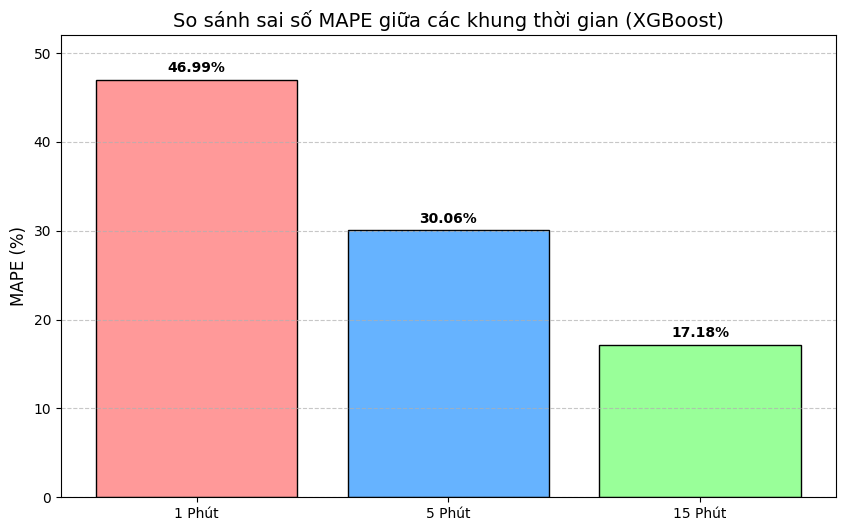

In [ ]:
import matplotlib.pyplot as plt

# Thay các giá trị mape_1m, mape, mape_15m bằng biến thực tế bạn đã tính
time_frames = ['1 Phút', '5 Phút', '15 Phút']
mape_scores = [mape_1m, mape, mape_15m]

plt.figure(figsize=(10, 6))
bars = plt.bar(time_frames, mape_scores, color=['#ff9999','#66b3ff','#99ff99'], edgecolor='black')

# Thêm nhãn giá trị lên đầu cột
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, f'{yval:.2f}%', ha='center', va='bottom', fontweight='bold')

plt.title('So sánh sai số MAPE giữa các khung thời gian (XGBoost)', fontsize=14)
plt.ylabel('MAPE (%)', fontsize=12)
plt.ylim(0, max(mape_scores) + 5) # Tạo khoảng trống phía trên cho đẹp
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
from prophet import Prophet
import pandas as pd

# 1. Reset index để lấy cột thời gian ra
df_prophet_5m = df_5m.reset_index()

# 2. Đổi tên cột theo đúng chuẩn của Prophet
df_prophet_5m = df_prophet_5m.rename(columns={'timestamp': 'ds', 'requests': 'y'})

# --- BƯỚC SỬA LỖI QUAN TRỌNG ---
# Loại bỏ thông tin múi giờ (Timezone) để Prophet không bị lỗi
df_prophet_5m['ds'] = df_prophet_5m['ds'].dt.tz_localize(None)
# -------------------------------

# [cite_start]3. Chia tập Train/Test [cite: 26-27]
split_date = '1995-08-23 00:00:00'
# Đảm bảo split_date cũng được hiểu là không có múi giờ để so sánh
split_date = pd.to_datetime(split_date)

train_prophet = df_prophet_5m[df_prophet_5m['ds'] < split_date]
test_prophet = df_prophet_5m[df_prophet_5m['ds'] >= split_date]

print("Đã xử lý xong lỗi Timezone!")
print(f"Train shape: {train_prophet.shape}")
print(f"Test shape: {test_prophet.shape}")
df_prophet_5m.head()

Đã xử lý xong lỗi Timezone!
Train shape: (15264, 4)
Test shape: (2592, 4)


,ds,y,total_bytes,errors
0,1995-07-01 00:00:00,301,5277675,1
1,1995-07-01 00:05:00,267,5041043,0
2,1995-07-01 00:10:00,242,6111846,4
3,1995-07-01 00:15:00,282,4559748,4
4,1995-07-01 00:20:00,319,7262385,0


In [ ]:
# Khởi tạo và huấn luyện lại
model_prophet = Prophet(daily_seasonality=True, weekly_seasonality=True)
model_prophet.fit(train_prophet)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [ ]:
# Tạo khung thời gian cần dự báo (chính là thời gian của tập Test)
future = test_prophet[['ds']]

# Thực hiện dự báo
forecast = model_prophet.predict(future)

# Xem kết quả (yhat là giá trị dự báo)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2587,1995-08-31 23:35:00,198.349130,-109.683830,530.555861
2588,1995-08-31 23:40:00,196.769989,-127.186298,517.253792
2589,1995-08-31 23:45:00,195.136402,-128.998524,524.551875
2590,1995-08-31 23:50:00,193.453076,-124.360834,527.005605
2591,1995-08-31 23:55:00,191.724791,-151.995883,527.752138


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Lấy giá trị thực tế và dự báo
y_true = test_prophet['y'].values
y_pred = forecast['yhat'].values

# Xử lý trường hợp dự báo ra số âm (Prophet đôi khi bị lỗi này với dữ liệu nhỏ)
y_pred = np.maximum(y_pred, 0)

# Tính toán chỉ số
mae_p = mean_absolute_error(y_true, y_pred)
mse_p = mean_squared_error(y_true, y_pred)
rmse_p = np.sqrt(mse_p)

# Tính MAPE (Loại bỏ số 0 để tránh lỗi chia cho 0)
mask = y_true > 0
mape_p = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

print("--- KẾT QUẢ PROPHET (Khung 5 Phút) ---")
print(f"MAE:  {mae_p:.2f}")
print(f"MSE: {mse_p:.2f}")
print(f"RMSE: {rmse_p:.2f}")
print(f"MAPE: {mape_p:.2f}%")

--- KẾT QUẢ PROPHET (Khung 5 Phút) ---
MAE:  62.71
MSE: 6911.05
RMSE: 83.13
MAPE: 46.29%


In [ ]:
import pandas as pd

# 1. Reset index và đổi tên cột theo chuẩn Prophet (ds, y)
df_prophet_1m = df_1m.reset_index().rename(columns={'timestamp': 'ds', 'requests': 'y'})

# 2. Loại bỏ múi giờ (Bước quan trọng để tránh lỗi)
df_prophet_1m['ds'] = df_prophet_1m['ds'].dt.tz_localize(None)

# 3. Chia tập Train/Test
split_date = pd.to_datetime('1995-08-23 00:00:00')

train_p_1m = df_prophet_1m[df_prophet_1m['ds'] < split_date]
test_p_1m = df_prophet_1m[df_prophet_1m['ds'] >= split_date]

print(f"Dữ liệu huấn luyện (1m): {train_p_1m.shape}")
print(f"Dữ liệu kiểm thử (1m): {test_p_1m.shape}")

Dữ liệu huấn luyện (1m): (76320, 4)
Dữ liệu kiểm thử (1m): (12960, 4)


In [ ]:
from prophet import Prophet

# Khởi tạo và huấn luyện
model_p_1m = Prophet(daily_seasonality=True, weekly_seasonality=True)
model_p_1m.fit(train_p_1m)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# 1. Dự báo trên tập Test
future_1m = test_p_1m[['ds']]
forecast_1m = model_p_1m.predict(future_1m)

# Xem kết quả (yhat là giá trị dự báo)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2587,1995-08-31 23:35:00,198.349130,-109.683830,530.555861
2588,1995-08-31 23:40:00,196.769989,-127.186298,517.253792
2589,1995-08-31 23:45:00,195.136402,-128.998524,524.551875
2590,1995-08-31 23:50:00,193.453076,-124.360834,527.005605
2591,1995-08-31 23:55:00,191.724791,-151.995883,527.752138


In [ ]:
# 2. Lấy giá trị thực và dự báo
y_true_1m = test_p_1m['y'].values
y_pred_1m = np.maximum(forecast_1m['yhat'].values, 0) # Xử lý số âm

# 3. Tính toán 4 chỉ số
mae_p_1m = mean_absolute_error(y_true_1m, y_pred_1m)
mse_p_1m = mean_squared_error(y_true_1m, y_pred_1m)
rmse_p_1m = np.sqrt(mse_p_1m)

mask = y_true_1m > 0
mape_p_1m = np.mean(np.abs((y_true_1m[mask] - y_pred_1m[mask]) / y_true_1m[mask])) * 100

print(f"--- KẾT QUẢ PROPHET (KHUNG 1 PHÚT) ---")
print(f"1. MAE:  {mae_p_1m:.2f}")
print(f"2. MSE:  {mse_p_1m:.2f}")
print(f"3. RMSE: {rmse_p_1m:.2f}")
print(f"4. MAPE: {mape_p_1m:.2f}%")

--- KẾT QUẢ PROPHET (KHUNG 1 PHÚT) ---
1. MAE:  15.89
2. MSE:  459.46
3. RMSE: 21.43
4. MAPE: 56.40%


In [ ]:
# 1. Reset index và đổi tên cột
df_prophet_15m = df_15m.reset_index().rename(columns={'timestamp': 'ds', 'requests': 'y'})

# 2. Loại bỏ múi giờ
df_prophet_15m['ds'] = df_prophet_15m['ds'].dt.tz_localize(None)

# 3. Chia tập Train/Test
train_p_15m = df_prophet_15m[df_prophet_15m['ds'] < split_date]
test_p_15m = df_prophet_15m[df_prophet_15m['ds'] >= split_date]

print(f"Dữ liệu huấn luyện (15m): {train_p_15m.shape}")
print(f"Dữ liệu kiểm thử (15m): {test_p_15m.shape}")

Dữ liệu huấn luyện (15m): (5088, 4)
Dữ liệu kiểm thử (15m): (864, 4)


In [ ]:
# Khởi tạo và huấn luyện
model_p_15m = Prophet(daily_seasonality=True, weekly_seasonality=True)
model_p_15m.fit(train_p_15m)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [ ]:
# 1. Dự báo
future_15m = test_p_15m[['ds']]
forecast_15m = model_p_15m.predict(future_15m)

# 2. Lấy giá trị
y_true_15m = test_p_15m['y'].values
y_pred_15m = np.maximum(forecast_15m['yhat'].values, 0)

# 3. Tính toán 4 chỉ số
mae_p_15m = mean_absolute_error(y_true_15m, y_pred_15m)
mse_p_15m = mean_squared_error(y_true_15m, y_pred_15m)
rmse_p_15m = np.sqrt(mse_p_15m)

mask = y_true_15m > 0
mape_p_15m = np.mean(np.abs((y_true_15m[mask] - y_pred_15m[mask]) / y_true_15m[mask])) * 100

print(f"--- KẾT QUẢ PROPHET (KHUNG 15 PHÚT) ---")
print(f"1. MAE:  {mae_p_15m:.2f}")
print(f"2. MSE:  {mse_p_15m:.2f}")
print(f"3. RMSE: {rmse_p_15m:.2f}")
print(f"4. MAPE: {mape_p_15m:.2f}%")

--- KẾT QUẢ PROPHET (KHUNG 15 PHÚT) ---
1. MAE:  169.35
2. MSE:  49474.29
3. RMSE: 222.43
4. MAPE: 34.62%


In [ ]:
import pandas as pd

# Tạo bảng so sánh từ các biến đã tính
benchmark_data = {
    'Khung giờ': ['1 Phút', '5 Phút', '15 Phút'],
    'XGBoost MAPE': [mape_1m, mape, mape_15m],   # Biến từ phần XGBoost
    'Prophet MAPE': [mape_p_1m, mape_p, mape_p_15m], # Biến từ phần Prophet
    'XGBoost RMSE': [rmse_1m, rmse, rmse_15m],
    'Prophet RMSE': [rmse_p_1m, rmse_p, rmse_p_15m]
}

df_benchmark = pd.DataFrame(benchmark_data)
print("=== BẢNG SO SÁNH HIỆU NĂNG (XGBOOST vs PROPHET) ===")
display(df_benchmark)

=== BẢNG SO SÁNH HIỆU NĂNG (XGBOOST vs PROPHET) ===


,Khung giờ,XGBoost MAPE,Prophet MAPE,XGBoost RMSE,Prophet RMSE
0,1 Phút,46.991199,56.397671,14.252770,21.434964
1,5 Phút,30.055946,46.293820,46.499527,83.132714
2,15 Phút,17.182155,34.618024,115.296552,222.428165


In [ ]:
import numpy as np
import pandas as pd
import keras
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 1. Lấy dữ liệu 5 phút
df_lstm = df_5m.copy()

# --- SỬA LỖI Ở ĐÂY ---
# Loại bỏ múi giờ khỏi Index để so sánh được với split_date
if df_lstm.index.tz is not None:
    df_lstm.index = df_lstm.index.tz_localize(None)
# ---------------------

data = df_lstm[['requests']].values

# 2. Chuẩn hóa dữ liệu về [0, 1] (Bắt buộc với Deep Learning)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# 3. Chia Train/Test theo ngày cắt
# Định nghĩa lại split_date cho chắc chắn
split_date = pd.to_datetime('1995-08-23 00:00:00')

train_size = len(df_lstm[df_lstm.index < split_date])
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# 4. Hàm tạo chuỗi (Sliding Window)
def create_dataset(dataset, look_back=12):
    X, Y = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 12 # Nhìn lại 1 tiếng trước
X_train, y_train = create_dataset(train_data, look_back)
X_test, y_test = create_dataset(test_data, look_back)

# Reshape input thành [Samples, Time Steps, Features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

print("Đã xử lý xong!")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

Đã xử lý xong!
X_train shape: (15251, 12, 1)
X_test shape: (2579, 12, 1)


In [ ]:
# 1. Khởi tạo mô hình
model_lstm = Sequential()
model_lstm.add(LSTM(100, return_sequences=False, input_shape=(look_back, 1))) # 50 nơ-ron
model_lstm.add(Dense(1)) # Output lớp dự báo

# 2. Compile (Thiết lập hàm mất mát)
model_lstm.compile(loss='mean_squared_error', optimizer='adam')

# 3. Huấn luyện (Train)
# Epochs=20: Học 20 vòng
# Batch_size=32: Mỗi lần học 32 mẫu
print("Đang huấn luyện LSTM (Có thể mất vài phút)...")
history = model_lstm.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Đang huấn luyện LSTM (Có thể mất vài phút)...
Epoch 1/20
477/477 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0023
Epoch 2/20
477/477 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0012
Epoch 3/20
477/477 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0011
Epoch 4/20
477/477 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0011
Epoch 5/20
477/477 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0011
Epoch 6/20
477/477 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0011
Epoch 7/20
477/477 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0011
Epoch 8/20
477/477 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0011
Epoch 9/20
477/477 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0011
Epoch 10/20
477/477 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0011
Epoch 11/20
477/477 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0011
Epoch 12/20
477/477 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0011
Epoch 13/20
477/477 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0011
Epoch 14/20
477/477 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0011
Epoch 15/20

In [ ]:
# 1. Dự báo
train_predict = model_lstm.predict(X_train)
test_predict = model_lstm.predict(X_test)

# 2. Đảo ngược chuẩn hóa (Inverse Transform) để về số lượng requests thực
train_predict = scaler.inverse_transform(train_predict)
y_train_inv = scaler.inverse_transform([y_train])
test_predict = scaler.inverse_transform(test_predict)
y_test_inv = scaler.inverse_transform([y_test])

# 3. Tính toán các chỉ số đánh giá cho tập Test
# Cần cắt bớt phần đầu của y_test_inv vì quá trình tạo window làm mất một số mẫu
y_true_lstm = y_test_inv[0]
y_pred_lstm = test_predict[:, 0]

mae_lstm = mean_absolute_error(y_true_lstm, y_pred_lstm)
mse_lstm = mean_squared_error(y_true_lstm, y_pred_lstm)
rmse_lstm = np.sqrt(mse_lstm)

# Tính MAPE (tránh chia cho 0)
mask = y_true_lstm > 0
mape_lstm = np.mean(np.abs((y_true_lstm[mask] - y_pred_lstm[mask]) / y_true_lstm[mask])) * 100

print(f"--- KẾT QUẢ LSTM (Khung 5 Phút) ---")
print(f"1. MAE:  {mae_lstm:.2f}")
print(f"2. MSE:  {mse_lstm:.2f}")
print(f"3. RMSE: {rmse_lstm:.2f}")
print(f"4. MAPE: {mape_lstm:.2f}%")

477/477 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
--- KẾT QUẢ LSTM (Khung 5 Phút) ---
1. MAE:  36.29
2. MSE:  2237.11
3. RMSE: 47.30
4. MAPE: 32.54%


In [ ]:
# 1. Chuẩn bị dữ liệu 1 phút
df_lstm_1m = df_1m.copy()
if df_lstm_1m.index.tz is not None:
    df_lstm_1m.index = df_lstm_1m.index.tz_localize(None)

data_1m = df_lstm_1m[['requests']].values
scaler_1m = MinMaxScaler(feature_range=(0, 1))
scaled_1m = scaler_1m.fit_transform(data_1m)

# 2. Chia Train/Test
train_size_1m = len(df_lstm_1m[df_lstm_1m.index < split_date])
train_1m = scaled_1m[:train_size_1m]
test_1m = scaled_1m[train_size_1m:]

# 3. Tạo Dataset (Nhìn lại 60 phút = 60 steps cho khung 1m)
look_back_1m = 60
X_train_1m, y_train_1m = create_dataset(train_1m, look_back_1m)
X_test_1m, y_test_1m = create_dataset(test_1m, look_back_1m)

X_train_1m = np.reshape(X_train_1m, (X_train_1m.shape[0], X_train_1m.shape[1], 1))
X_test_1m = np.reshape(X_test_1m, (X_test_1m.shape[0], X_test_1m.shape[1], 1))

print(f"X_train_1m shape: {X_train_1m.shape}")
print(f"X_test_1m shape: {X_test_1m.shape}")

X_train_1m shape: (76259, 60, 1)
X_test_1m shape: (12899, 60, 1)


In [ ]:
# Khởi tạo và huấn luyện
model_1m = Sequential()
model_1m.add(LSTM(50, input_shape=(look_back_1m, 1)))
model_1m.add(Dense(1))
model_1m.compile(loss='mean_squared_error', optimizer='adam')

print("Đang huấn luyện LSTM 1m...")
model_1m.fit(X_train_1m, y_train_1m, epochs=10, batch_size=64, verbose=1)

Đang huấn luyện LSTM 1m...
Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1192/1192 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.0016
Epoch 2/10
1192/1192 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0012
Epoch 3/10
1192/1192 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0012
Epoch 4/10
1192/1192 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.0012
Epoch 5/10
1192/1192 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.0012
Epoch 6/10
1192/1192 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.0012
Epoch 7/10
1192/1192 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0012
Epoch 8/10
1192/1192 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0011
Epoch 9/10
1192/1192 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.0012
Epoch 10/10
1192/1192 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0012


In [ ]:
# --- ĐÁNH GIÁ ĐẦY ĐỦ 4 CHỈ SỐ CHO 1 PHÚT ---
# Dự báo và tính chỉ số
pred_1m = model_1m.predict(X_test_1m)
pred_1m = scaler_1m.inverse_transform(pred_1m)
y_true_1m = scaler_1m.inverse_transform([y_test_1m])[0]
y_pred_1m = pred_1m[:, 0]

# Tính 4 thông số
mae_lstm_1m = mean_absolute_error(y_true_1m, y_pred_1m)
mse_lstm_1m = mean_squared_error(y_true_1m, y_pred_1m)
rmse_lstm_1m = np.sqrt(mse_lstm_1m)

mask = y_true_1m > 0
mape_lstm_1m = np.mean(np.abs((y_true_1m[mask] - y_pred_1m[mask]) / y_true_1m[mask])) * 100

print(f"--- KẾT QUẢ LSTM (KHUNG 1 PHÚT) ---")
print(f"1. MAE:  {mae_lstm_1m:.2f}")
print(f"2. MSE:  {mse_lstm_1m:.2f}")
print(f"3. RMSE: {rmse_lstm_1m:.2f}")
print(f"4. MAPE: {mape_lstm_1m:.2f}%")

404/404 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
--- KẾT QUẢ LSTM (KHUNG 1 PHÚT) ---
1. MAE:  10.55
2. MSE:  192.08
3. RMSE: 13.86
4. MAPE: 46.65%


In [ ]:
# 1. Chuẩn bị dữ liệu 15 phút
df_lstm_15m = df_15m.copy()
if df_lstm_15m.index.tz is not None:
    df_lstm_15m.index = df_lstm_15m.index.tz_localize(None)

data_15m = df_lstm_15m[['requests']].values
scaler_15m = MinMaxScaler(feature_range=(0, 1))
scaled_15m = scaler_15m.fit_transform(data_15m)

# 2. Chia Train/Test
train_size_15m = len(df_lstm_15m[df_lstm_15m.index < split_date])
train_15m = scaled_15m[:train_size_15m]
test_15m = scaled_15m[train_size_15m:]

# 3. Tạo Dataset (Nhìn lại 1 tiếng = 4 steps cho khung 15m)
look_back_15m = 4
X_train_15m, y_train_15m = create_dataset(train_15m, look_back_15m)
X_test_15m, y_test_15m = create_dataset(test_15m, look_back_15m)

X_train_15m = np.reshape(X_train_15m, (X_train_15m.shape[0], X_train_15m.shape[1], 1))
X_test_15m = np.reshape(X_test_15m, (X_test_15m.shape[0], X_test_15m.shape[1], 1))

print(f"X_train_15m shape: {X_train_15m.shape}")
print(f"X_test_15m shape: {X_test_15m.shape}")

X_train_15m shape: (5083, 4, 1)
X_test_15m shape: (859, 4, 1)


In [ ]:
# Khởi tạo và huấn luyện
model_15m = Sequential()
model_15m.add(LSTM(50, input_shape=(look_back_15m, 1)))
model_15m.add(Dense(1))
model_15m.compile(loss='mean_squared_error', optimizer='adam')

print("Đang huấn luyện LSTM 15m...")
model_15m.fit(X_train_15m, y_train_15m, epochs=20, batch_size=32, verbose=1)

Đang huấn luyện LSTM 15m...
Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0069
Epoch 2/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0012
Epoch 3/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0012
Epoch 4/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0012
Epoch 5/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0012
Epoch 6/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0010
Epoch 7/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 9.7607e-04
Epoch 8/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 9.6274e-04
Epoch 9/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0011
Epoch 10/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 9.7886e-04
Epoch 11/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0010
Epoch 12/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 9.5660e-04
Epoch 13/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 9.3695e-04
Epoch 14/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 9.9860e-04
Epoch 15/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 

In [ ]:
# --- ĐÁNH GIÁ ĐẦY ĐỦ 4 CHỈ SỐ CHO 15 PHÚT ---
# 1. Dự báo trên tập Test
pred_15m = model_15m.predict(X_test_15m)

# 2. Đảo ngược chuẩn hóa để về giá trị thực
pred_15m = scaler_15m.inverse_transform(pred_15m)
y_true_15m = scaler_15m.inverse_transform([y_test_15m])[0]
y_pred_15m = pred_15m[:, 0]

# 3. Tính toán 4 thông số theo yêu cầu
mae_lstm_15m = mean_absolute_error(y_true_15m, y_pred_15m)
mse_lstm_15m = mean_squared_error(y_true_15m, y_pred_15m)
rmse_lstm_15m = np.sqrt(mse_lstm_15m)

# Tính MAPE (loại bỏ giá trị 0 để tránh lỗi chia cho 0)
mask_15m = y_true_15m > 0
mape_lstm_15m = np.mean(np.abs((y_true_15m[mask_15m] - y_pred_15m[mask_15m]) / y_true_15m[mask_15m])) * 100

# 4. Hiển thị kết quả
print(f"--- KẾT QUẢ LSTM (KHUNG 15 PHÚT) ---")
print(f"1. MAE:  {mae_lstm_15m:.2f}")
print(f"2. MSE:  {mse_lstm_15m:.2f}")
print(f"3. RMSE: {rmse_lstm_15m:.2f}")
print(f"4. MAPE: {mape_lstm_15m:.2f}%")

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
--- KẾT QUẢ LSTM (KHUNG 15 PHÚT) ---
1. MAE:  86.45
2. MSE:  13992.58
3. RMSE: 118.29
4. MAPE: 16.96%


--- KIỂM TRA TÍNH DỪNG ---
ADF Statistic: -9.8891
p-value: 0.0000
=> Dữ liệu đã dừng (Stationary).


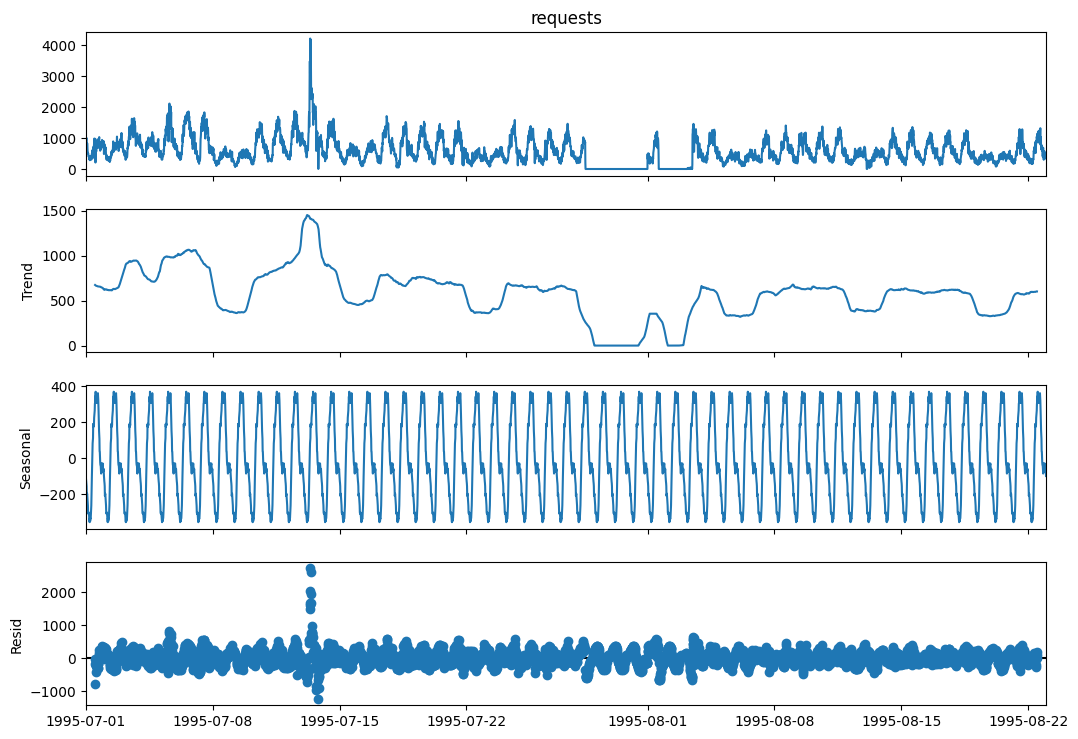

In [ ]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import pandas as pd
import matplotlib.pyplot as plt

# 1. Chuẩn bị dữ liệu và SỬA LỖI TIMEZONE
df_sarima_15m = df_15m.copy()

# Loại bỏ múi giờ nếu có để đồng nhất với split_date
if df_sarima_15m.index.tz is not None:
    df_sarima_15m.index = df_sarima_15m.index.tz_localize(None)

# Đảm bảo split_date cũng ở dạng Timestamp không múi giờ
split_dt = pd.to_datetime('1995-08-23 00:00:00')

# Chia tập Train/Test
train_15m = df_sarima_15m[df_sarima_15m.index < split_dt].copy()
test_15m = df_sarima_15m[df_sarima_15m.index >= split_dt].copy()

# Thiết lập tần suất bắt buộc cho SARIMA
train_15m.index.freq = '15min'
test_15m.index.freq = '15min'

# 2. Kiểm định ADF (Tính "Dừng")
def test_stationarity(timeseries):
    # dropna() để đảm bảo không có giá trị trống khi kiểm định
    result = adfuller(timeseries.dropna())
    print(f'ADF Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    if result[1] <= 0.05:
        print("=> Dữ liệu đã dừng (Stationary).")
    else:
        print("=> Dữ liệu chưa dừng, cần lấy hiệu số (d=1).")

print("--- KIỂM TRA TÍNH DỪNG ---")
test_stationarity(train_15m['requests'])

# 3. Phân rã dữ liệu (Decomposition)
# period=96 vì 1 ngày có 96 mốc 15 phút (24 * 4)
decomposition = seasonal_decompose(train_15m['requests'], model='additive', period=96)
fig = decomposition.plot()
fig.set_size_inches(12, 8)
plt.show()

In [ ]:
!pip install pmdarima
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pmdarima as pm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Tạo bản sao dữ liệu để chạy ARIMA
train_arima = train_15m.copy()
test_arima = test_15m.copy()

print("Đã nạp thư viện và chuẩn bị dữ liệu xong!")
print(f"Kích thước tập Train: {len(train_arima)}")
print(f"Kích thước tập Test: {len(test_arima)}")

Đã nạp thư viện và chuẩn bị dữ liệu xong!
Kích thước tập Train: 5088
Kích thước tập Test: 864


In [ ]:
print("Đang tìm bộ tham số tối ưu ...")

# seasonal=False giúp mô hình chạy nhanh gấp 20 lần so với SARIMA
model_auto = pm.auto_arima(train_arima['requests'],
                          seasonal=False,       # TẮT MÙA VỤ
                          start_p=0, start_q=0,
                          max_p=5, max_q=5,     # Tìm kiếm rộng hơn
                          d=1,                  # Ép sai phân bậc 1 để khử xu hướng
                          trace=True,           # Hiện thông báo từng bước
                          error_action='ignore',
                          suppress_warnings=True)

print(f"\n Bộ tham số tốt nhất tìm được: {model_auto.order}")

Đang tìm bộ tham số tối ưu ...
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=64277.468, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=63868.308, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=63760.451, Time=0.40 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=64275.470, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=63755.538, Time=1.87 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=63747.111, Time=6.43 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=63754.006, Time=0.77 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=63746.941, Time=6.39 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=63745.451, Time=1.97 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=63747.220, Time=2.09 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=63749.143, Time=2.35 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=63743.457, Time=0.72 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=63752.012, Time=0.49 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=63745.226, Ti

In [ ]:
my_order = model_auto.order
print(f"Đang huấn luyện mô hình ARIMA{my_order}...")

# 1. Huấn luyện
model = ARIMA(train_arima['requests'], order=my_order)
model_fit = model.fit()

# 2. Dự báo
print("Đang thực hiện dự báo...")
# Dự báo cho số bước bằng đúng độ dài tập test
forecast_result = model_fit.get_forecast(steps=len(test_arima))
y_pred_arima = forecast_result.predicted_mean

# Gán lại index thời gian cho kết quả dự báo để vẽ biểu đồ cho chuẩn
y_pred_arima.index = test_arima.index

print("Đã dự báo xong!")

Đang huấn luyện mô hình ARIMA(3, 1, 0)...
Đang thực hiện dự báo...
Đã dự báo xong!


In [ ]:
# 1. Tính toán các chỉ số
y_true = test_arima['requests'].values
mae = mean_absolute_error(y_true, y_pred_arima)
mse = mean_squared_error(y_true, y_pred_arima)
rmse = np.sqrt(mse)

# Tính MAPE (loại bỏ các điểm bằng 0 để tránh lỗi chia cho 0)
mask = y_true > 0
mape = np.mean(np.abs((y_true[mask] - y_pred_arima.values[mask]) / y_true[mask])) * 100

print(f"--- KẾT QUẢ ĐÁNH GIÁ ARIMA ---")
print(f"MAE:  {mae:.2f}")
print(f"MSE:  {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

--- KẾT QUẢ ĐÁNH GIÁ ARIMA ---
MAE:  300.93
MSE:  174475.30
RMSE: 417.70
MAPE: 49.26%


In [ ]:
# --- CELL 1 (5m): CHUẨN BỊ DỮ LIỆU ---
import pandas as pd

# 1. Copy và xử lý Timezone
df_sarima_5m = df_5m.copy()
if df_sarima_5m.index.tz is not None:
    df_sarima_5m.index = df_sarima_5m.index.tz_localize(None)

# 2. Chia Train/Test (Split date: 23/08)
split_dt = pd.to_datetime('1995-08-23 00:00:00')

train_5m = df_sarima_5m[df_sarima_5m.index < split_dt].copy()
test_5m = df_sarima_5m[df_sarima_5m.index >= split_dt].copy()

# 3. Thiết lập tần suất (Bắt buộc cho 5 phút)
train_5m.index.freq = '5min'
test_5m.index.freq = '5min'

print(f"Kích thước Train 5m: {len(train_5m)}")
print(f"Kích thước Test 5m: {len(test_5m)}")

Kích thước Train 5m: 15264
Kích thước Test 5m: 2592


ADF Statistic: -9.5118
p-value: 0.0000
=> Dữ liệu 5m đã dừng.

Đang vẽ biểu đồ phân rã (Seasonal Decompose)...


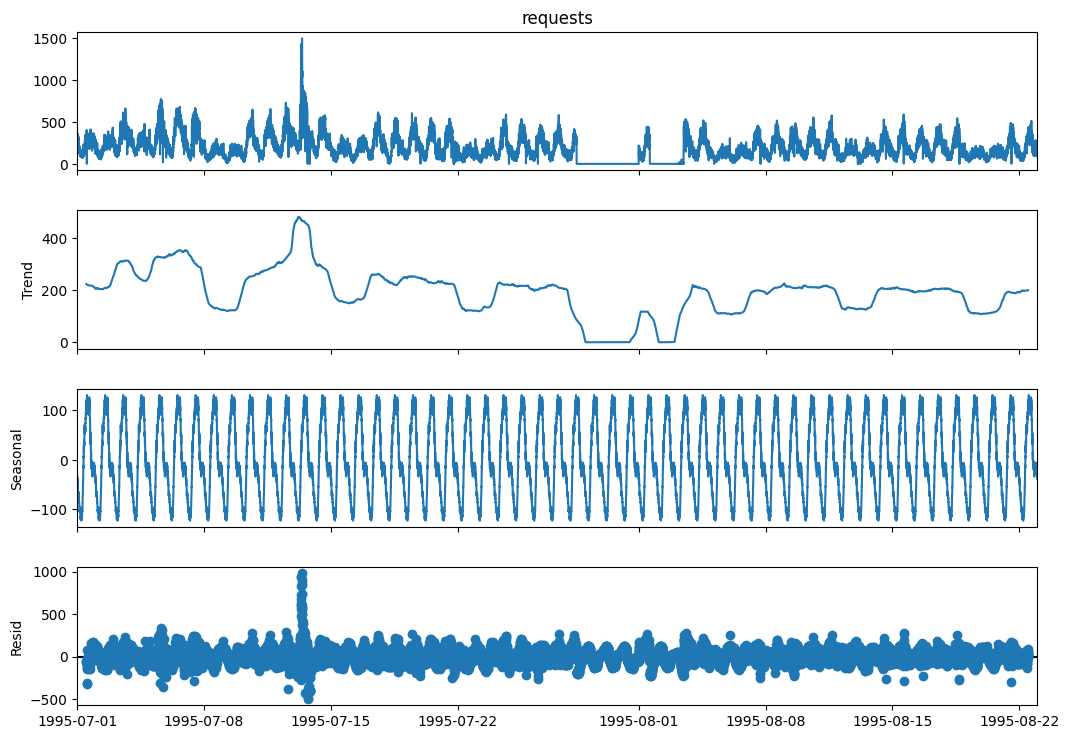

In [ ]:
# --- CELL 2 (5m): KIỂM ĐỊNH & PHÂN RÃ ---
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# 1. Kiểm định tính dừng
result = adfuller(train_5m['requests'].dropna())
print(f'ADF Statistic: {result[0]:.4f}')
print(f'p-value: {result[1]:.4f}')
if result[1] <= 0.05:
    print("=> Dữ liệu 5m đã dừng.")
else:
    print("=> Dữ liệu 5m chưa dừng, ARIMA sẽ tự lấy d=1.")

# 2. Phân rã (Period = 288 cho khung 5 phút)
print("\nĐang vẽ biểu đồ phân rã (Seasonal Decompose)...")
# period = 12 mốc/giờ * 24 giờ = 288
decomposition = seasonal_decompose(train_5m['requests'], model='additive', period=288)
fig = decomposition.plot()
fig.set_size_inches(12, 8)
plt.show()

In [ ]:
# --- CELL 3 (5m): AUTO-ARIMA & HUẤN LUYỆN ---
import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA

print("⏳ Đang tìm tham số tối ưu cho khung 5 phút...")
# Dùng tập mẫu nhỏ hơn 1 chút nếu máy yếu, nhưng 5m thường vẫn chạy ổn với full data
model_auto_5m = pm.auto_arima(train_5m['requests'],
                             seasonal=False,       # TẮT MÙA VỤ
                             start_p=0, start_q=0,
                             max_p=5, max_q=5,
                             d=1,
                             trace=True,
                             error_action='ignore',
                             suppress_warnings=True)

print(f"\n🎉 Bộ tham số tốt nhất (5m): {model_auto_5m.order}")

# Huấn luyện mô hình chính thức
print(f"🚀 Đang huấn luyện ARIMA{model_auto_5m.order}...")
model_5m = ARIMA(train_5m['requests'], order=model_auto_5m.order)
model_fit_5m = model_5m.fit()

# Dự báo
print("🔮 Đang dự báo...")
forecast_result_5m = model_fit_5m.get_forecast(steps=len(test_5m))
y_pred_5m = forecast_result_5m.predicted_mean
y_pred_5m.index = test_5m.index
print("✅ Xong!")

⏳ Đang tìm tham số tối ưu cho khung 5 phút...
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=166254.669, Time=0.98 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=164291.629, Time=1.48 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=162715.926, Time=7.48 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=166252.669, Time=0.51 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=162347.165, Time=12.77 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=162347.631, Time=18.29 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=162347.820, Time=11.57 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=162361.007, Time=7.92 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=163409.862, Time=1.68 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=162351.143, Time=12.24 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=162345.172, Time=1.74 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=162713.930, Time=1.24 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=164289.630, Time=0.29 sec
 ARIMA(2,1,1)(0,0,0)[0]

In [ ]:
# --- CELL 4 (5m): ĐÁNH GIÁ KẾT QUẢ ---
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

y_true = test_5m['requests'].values
mae = mean_absolute_error(y_true, y_pred_5m)
mse = mean_squared_error(y_true, y_pred_5m)
rmse = np.sqrt(mse)

mask = y_true > 0
mape = np.mean(np.abs((y_true[mask] - y_pred_5m.values[mask]) / y_true[mask])) * 100

print(f"--- KẾT QUẢ ARIMA (KHUNG 5 PHÚT) ---")
print(f"MAE:  {mae:.2f}")
print(f"MSE:  {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

--- KẾT QUẢ ARIMA (KHUNG 5 PHÚT) ---
MAE:  102.65
MSE:  20127.68
RMSE: 141.87
MAPE: 58.88%


In [ ]:
# --- CELL 1 (1m Full): CHUẨN BỊ DỮ LIỆU ---
import pandas as pd

# 1. Copy và xử lý Timezone
df_sarima_1m = df_1m.copy()

# Loại bỏ múi giờ (nếu có) để tránh lỗi khi so sánh ngày tháng
if df_sarima_1m.index.tz is not None:
    df_sarima_1m.index = df_sarima_1m.index.tz_localize(None)

# 2. Chia Train/Test (Split date: 23/08)
split_dt = pd.to_datetime('1995-08-23 00:00:00')

# LẤY TOÀN BỘ DỮ LIỆU (Không cắt tail)
train_1m = df_sarima_1m[df_sarima_1m.index < split_dt].copy()
test_1m = df_sarima_1m[df_sarima_1m.index >= split_dt].copy()

# 3. Thiết lập tần suất '1min' (Bắt buộc cho ARIMA)
train_1m.index.freq = '1min'
test_1m.index.freq = '1min'

print(f"✅ Đã chuẩn bị xong dữ liệu 1 phút (Full Data).")
print(f"Kích thước Train 1m: {len(train_1m)} dòng")
print(f"Kích thước Test 1m: {len(test_1m)} dòng")

✅ Đã chuẩn bị xong dữ liệu 1 phút (Full Data).
Kích thước Train 1m: 76320 dòng
Kích thước Test 1m: 12960 dòng


In [ ]:
# --- CELL 2 (1m Full): KIỂM TRA TÍNH DỪNG ---
from statsmodels.tsa.stattools import adfuller

print("⏳ Đang kiểm tra tính dừng trên toàn bộ tập Train (Có thể mất vài giây)...")

# dropna() để loại bỏ các giá trị trống nếu có
result = adfuller(train_1m['requests'].dropna())

print(f'ADF Statistic: {result[0]:.4f}')
print(f'p-value: {result[1]:.4f}')

if result[1] <= 0.05:
    print("=> Kết luận: Dữ liệu ĐÃ DỪNG (Stationary).")
else:
    print("=> Kết luận: Dữ liệu CHƯA DỪNG, mô hình sẽ tự động lấy sai phân (d=1).")

⏳ Đang kiểm tra tính dừng trên toàn bộ tập Train (Có thể mất vài giây)...
ADF Statistic: -7.3823
p-value: 0.0000
=> Kết luận: Dữ liệu ĐÃ DỪNG (Stationary).


In [ ]:
# --- CELL 3 (1m Full): TÌM THAM SỐ & HUẤN LUYỆN ---
import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA
import time

print("⏳ Đang tìm tham số tối ưu trên TOÀN BỘ dữ liệu 1 phút...")
print("⚠️ CẢNH BÁO: Quá trình này có thể mất 15-30 phút. Hãy kiên nhẫn!")

start_time = time.time()

# 1. Tìm tham số tự động (Auto ARIMA)
# Dùng toàn bộ train_1m['requests'] thay vì tập con
model_auto_1m = pm.auto_arima(train_1m['requests'],
                             seasonal=False,       # BẮT BUỘC TẮT MÙA VỤ VỚI DATA LỚN
                             start_p=0, start_q=0,
                             max_p=4, max_q=4,     # Giảm giới hạn xuống 4 để tìm nhanh hơn chút
                             d=1,                  # Ép d=1 vì dữ liệu web luôn biến động
                             trace=True,           # Hiện log để biết nó chưa bị treo
                             error_action='ignore',
                             suppress_warnings=True,
                             stepwise=True)        # Tìm kiếm kiểu leo đồi (nhanh hơn vét cạn)

search_time = time.time() - start_time
print(f"\n🎉 Tìm thấy bộ tham số tốt nhất: {model_auto_1m.order}")
print(f"⏱️ Thời gian tìm kiếm: {search_time/60:.2f} phút")

# 2. Huấn luyện mô hình chính thức
print(f"🚀 Đang huấn luyện lại mô hình ARIMA{model_auto_1m.order} trên full dữ liệu...")
model_1m = ARIMA(train_1m['requests'], order=model_auto_1m.order)
model_fit_1m = model_1m.fit()

# 3. Dự báo
print("🔮 Đang thực hiện dự báo cho tập Test...")
forecast_result_1m = model_fit_1m.get_forecast(steps=len(test_1m))
y_pred_1m = forecast_result_1m.predicted_mean

# Gán index thời gian để vẽ biểu đồ
y_pred_1m.index = test_1m.index
print("✅ Hoàn tất quy trình!")

⏳ Đang tìm tham số tối ưu trên TOÀN BỘ dữ liệu 1 phút...
⚠️ CẢNH BÁO: Quá trình này có thể mất 15-30 phút. Hãy kiên nhẫn!
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=644021.455, Time=1.25 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=631885.028, Time=1.59 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=620773.961, Time=11.61 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=644019.455, Time=0.55 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=617252.482, Time=17.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=616983.778, Time=24.80 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=627183.396, Time=2.71 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=616936.706, Time=39.25 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=624073.386, Time=5.44 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=616838.312, Time=44.19 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=622515.604, Time=7.83 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=616843.086, Time=125.36 sec
 ARIMA(3,1,2

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


🔮 Đang thực hiện dự báo cho tập Test...
✅ Hoàn tất quy trình!


--- KẾT QUẢ ARIMA (KHUNG 1 PHÚT - FULL DATA) ---
1. MAE:  21.76
2. MSE:  901.97
3. RMSE: 30.03
4. MAPE: 84.39%


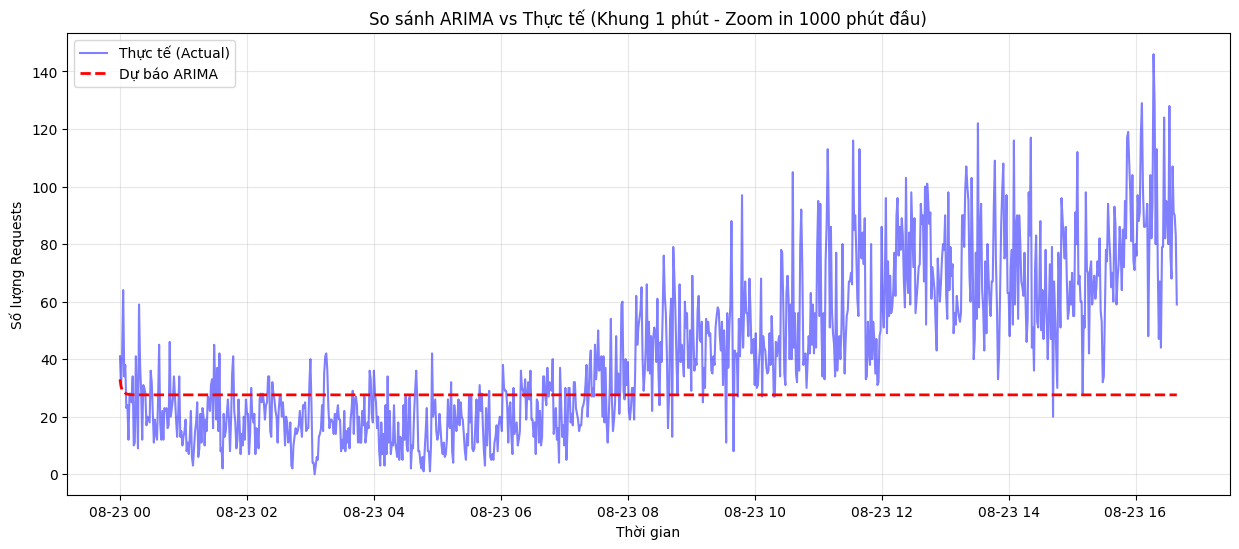

In [ ]:
# --- CELL 4 (1m Full): ĐÁNH GIÁ KẾT QUẢ ---
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# 1. Tính toán các chỉ số
y_true = test_1m['requests'].values
mae = mean_absolute_error(y_true, y_pred_1m)
mse = mean_squared_error(y_true, y_pred_1m)
rmse = np.sqrt(mse)

# Tính MAPE (loại bỏ các điểm bằng 0)
mask = y_true > 0
mape = np.mean(np.abs((y_true[mask] - y_pred_1m.values[mask]) / y_true[mask])) * 100

print(f"--- KẾT QUẢ ARIMA (KHUNG 1 PHÚT - FULL DATA) ---")
print(f"1. MAE:  {mae:.2f}")
print(f"2. MSE:  {mse:.2f}")
print(f"3. RMSE: {rmse:.2f}")
print(f"4. MAPE: {mape:.2f}%")

# 2. Vẽ biểu đồ (Chỉ vẽ 1000 điểm đầu tiên của tập Test để nhìn cho rõ, vẽ cả triệu điểm sẽ bị rối)
plt.figure(figsize=(15, 6))
limit_plot = 1000  # Chỉ vẽ 1000 phút đầu tiên của tập Test
plt.plot(test_1m.index[:limit_plot], y_true[:limit_plot], label='Thực tế (Actual)', color='blue', alpha=0.5)
plt.plot(test_1m.index[:limit_plot], y_pred_1m[:limit_plot], label='Dự báo ARIMA', color='red', linewidth=2, linestyle='--')

plt.title(f'So sánh ARIMA vs Thực tế (Khung 1 phút - Zoom in {limit_plot} phút đầu)')
plt.ylabel('Số lượng Requests')
plt.xlabel('Thời gian')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
# --- CELL 1: IMPORT VÀ TẠO ĐẶC TRƯNG ---
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

def enhance_features(df):
    df = df.copy()

    # --- 1. NHÓM CƠ BẢN ---
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['is_weekend'] = df.index.dayofweek.isin([5, 6]).astype(int)

    # --- 2. NHÓM TIME BINS (MỚI) ---
    # Chia buổi: 0-6: Đêm(0), 6-12: Sáng(1), 12-18: Chiều(2), 18-24: Tối(3)
    # pd.cut giúp chia khoảng số thành các nhóm
    df['part_of_day'] = pd.cut(df['hour'],
                               bins=[-1, 5, 11, 17, 23],
                               labels=[0, 1, 2, 3]).astype(int)

    # --- 3. NHÓM CHU KỲ SIN/COS (MỚI - Giúp nối liền 23h và 0h) ---
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

    # --- 4. LAG FEATURES (Giữ nguyên) ---
    for i in range(1, 4):
        df[f'lag_{i}'] = df['requests'].shift(i)

    # --- 5. ROLLING STATS (MỞ RỘNG) ---
    # Quan trọng: Vẫn phải shift(1) để chống Leakage
    window_size = 3
    df_shifted = df['requests'].shift(1)

    df['rolling_mean'] = df_shifted.rolling(window=window_size).mean()
    df['rolling_std'] = df_shifted.rolling(window=window_size).std() # Độ biến động
    df['rolling_max'] = df_shifted.rolling(window=window_size).max() # Đỉnh cao nhất gần đây

    return df.dropna()

# 2. Áp dụng vào dữ liệu 1 phút (train_1m, test_1m)
# Đảm bảo bạn đã chạy code tạo train_1m/test_1m ở các bước trước đó
print("🛠️ Đang tạo đặc trưng (Feature Engineering)...")
train_final = enhance_features(train_1m)
test_final = enhance_features(test_1m)

print(f"✅ Xong! Kích thước train_final: {train_final.shape}")
print(f"✅ Xong! Kích thước test_final: {test_final.shape}")

🛠️ Đang tạo đặc trưng (Feature Engineering)...
✅ Xong! Kích thước train_final: (76317, 15)
✅ Xong! Kích thước test_final: (12957, 15)


In [ ]:
# --- CELL 2: CHUẨN BỊ DỮ LIỆU (X, y) ---
# Thêm 'minute' vào danh sách này
features = ['hour', 'dayofweek', 'is_weekend','part_of_day','hour_sin','hour_cos', 'lag_1', 'lag_2', 'lag_3', 'rolling_mean','rolling_std','rolling_max']

# Tách X và y
X_train, y_train = train_final[features], train_final['requests']
X_test, y_test = test_final[features], test_final['requests']

print("📊 Dữ liệu đã sẵn sàng!")
print(f"Features: {features}")

📊 Dữ liệu đã sẵn sàng!
Features: ['hour', 'dayofweek', 'is_weekend', 'part_of_day', 'hour_sin', 'hour_cos', 'lag_1', 'lag_2', 'lag_3', 'rolling_mean', 'rolling_std', 'rolling_max']


In [ ]:
# --- CELL 3: HUẤN LUYỆN LIGHTGBM ---
import time

print("🚀 Đang huấn luyện LightGBM...")
start_time = time.time()

# 1. Khởi tạo mô hình
model = lgb.LGBMRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    num_leaves=31,       # Tham số quan trọng của LightGBM
    random_state=42,
    n_jobs=-1            # Dùng tất cả nhân CPU
)

# 2. Huấn luyện (Fit)
model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric='rmse'
)

train_time = time.time() - start_time
print(f"\n✅ Huấn luyện xong trong: {train_time:.2f} giây")

🚀 Đang huấn luyện LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003027 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1563
[LightGBM] [Info] Number of data points in the train set: 76317, number of used features: 12
[LightGBM] [Info] Start training from score 38.455403

✅ Huấn luyện xong trong: 8.34 giây


In [ ]:
# --- CELL 4: ĐÁNH GIÁ CHỈ SỐ ---
# 1. Dự báo
preds = model.predict(X_test)

# 2. Tính toán các chỉ số
mae = mean_absolute_error(y_test, preds)
mse = mean_squared_error(y_test, preds)
rmse = np.sqrt(mse)

# Tính MAPE (xử lý mẫu số 0)
mask = y_test > 0
mape = np.mean(np.abs((y_test[mask] - preds[mask]) / y_test[mask])) * 100

print(f"--- KẾT QUẢ LIGHTGBM (KHUNG 1 PHÚT) ---")
print(f"1. MAE:  {mae:.2f}")
print(f"2. MSE:  {mse:.2f}")
print(f"3. RMSE: {rmse:.2f}")
print(f"4. MAPE: {mape:.2f}%")

--- KẾT QUẢ LIGHTGBM (KHUNG 1 PHÚT) ---
1. MAE:  10.87
2. MSE:  208.01
3. RMSE: 14.42
4. MAPE: 47.24%


In [ ]:
# --- CELL 1 (15m): CHUẨN BỊ DỮ LIỆU ---
print("🛠️ Đang xử lý dữ liệu 15 phút...")

# 1. Tạo đặc trưng từ dữ liệu gốc df_15m
train_15m_feat = enhance_features(train_15m)
test_15m_feat = enhance_features(test_15m)

# 2. Tách X, y (Có cột 'minute')
features = ['hour', 'dayofweek', 'is_weekend','part_of_day','hour_sin','hour_cos', 'lag_1', 'lag_2', 'lag_3', 'rolling_mean','rolling_std','rolling_max']

X_train_15m = train_15m_feat[features]
y_train_15m = train_15m_feat['requests']

X_test_15m = test_15m_feat[features]
y_test_15m = test_15m_feat['requests']

print(f"✅ Sẵn sàng! Train shape: {X_train_15m.shape} | Test shape: {X_test_15m.shape}")
print(f"Features: {features}")

🛠️ Đang xử lý dữ liệu 15 phút...
✅ Sẵn sàng! Train shape: (5085, 12) | Test shape: (861, 12)
Features: ['hour', 'dayofweek', 'is_weekend', 'part_of_day', 'hour_sin', 'hour_cos', 'lag_1', 'lag_2', 'lag_3', 'rolling_mean', 'rolling_std', 'rolling_max']


In [ ]:
# --- CELL 2 (15m): HUẤN LUYỆN LIGHTGBM ---
print("🚀 Đang huấn luyện LightGBM cho khung 15 phút...")
start_time = time.time()

# Khởi tạo mô hình
model_15m = lgb.LGBMRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    num_leaves=31,
    random_state=42,
    n_jobs=-1
)

# Huấn luyện
model_15m.fit(
    X_train_15m, y_train_15m,
    eval_set=[(X_test_15m, y_test_15m)],
    eval_metric='rmse'
)

time_15m = time.time() - start_time
print(f"\n✅ Huấn luyện xong trong: {time_15m:.2f} giây")

🚀 Đang huấn luyện LightGBM cho khung 15 phút...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002577 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1607
[LightGBM] [Info] Number of data points in the train set: 5085, number of used features: 12
[LightGBM] [Info] Start training from score 576.637168

✅ Huấn luyện xong trong: 1.48 giây


--- KẾT QUẢ LIGHTGBM (KHUNG 15 PHÚT) ---
1. MAE:  86.75
2. MSE:  15153.61
3. RMSE: 123.10
4. MAPE: 17.49%
5. Thời gian: 1.48s


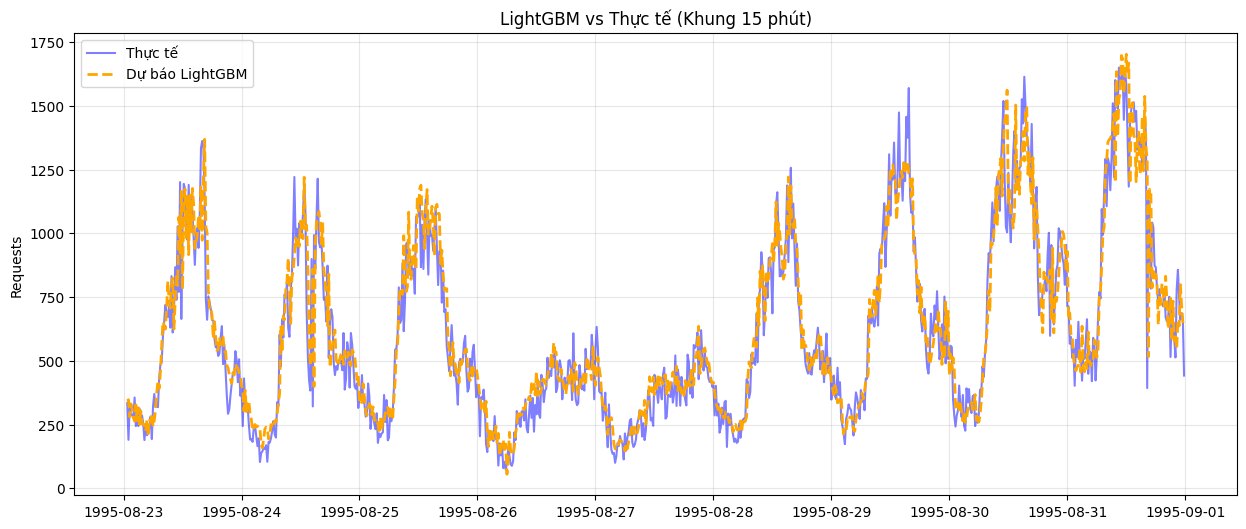

In [ ]:
# --- CELL 3 (15m): ĐÁNH GIÁ KẾT QUẢ (FULL 4 CHỈ SỐ) ---
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# 1. Dự báo
preds_15m = model_15m.predict(X_test_15m)

# 2. Tính toán đủ 4 chỉ số
mae = mean_absolute_error(y_test_15m, preds_15m)
mse = mean_squared_error(y_test_15m, preds_15m)  # <--- Đã thêm MSE
rmse = np.sqrt(mse)

mask = y_test_15m > 0
mape = np.mean(np.abs((y_test_15m[mask] - preds_15m[mask]) / y_test_15m[mask])) * 100

print(f"--- KẾT QUẢ LIGHTGBM (KHUNG 15 PHÚT) ---")
print(f"1. MAE:  {mae:.2f}")   # <--- Đã bổ sung
print(f"2. MSE:  {mse:.2f}")   # <--- Đã bổ sung
print(f"3. RMSE: {rmse:.2f}")
print(f"4. MAPE: {mape:.2f}%")
print(f"5. Thời gian: {time_15m:.2f}s")

# 3. Vẽ biểu đồ
plt.figure(figsize=(15, 6))
plt.plot(y_test_15m.index, y_test_15m, label='Thực tế', color='blue', alpha=0.5)
plt.plot(y_test_15m.index, preds_15m, label='Dự báo LightGBM', color='orange', linewidth=2, linestyle='--')
plt.title('LightGBM vs Thực tế (Khung 15 phút)')
plt.ylabel('Requests')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
# --- CELL 1 (5m): CHUẨN BỊ DỮ LIỆU ---
print("🛠️ Đang xử lý dữ liệu 5 phút...")

# 1. Tạo đặc trưng từ dữ liệu gốc df_5m
train_5m_feat = enhance_features(train)
test_5m_feat = enhance_features(test)

# 2. Tách X, y (Dùng chung list features ở trên)
X_train_5m = train_5m_feat[features]
y_train_5m = train_5m_feat['requests']

X_test_5m = test_5m_feat[features]
y_test_5m = test_5m_feat['requests']

print(f"✅ Sẵn sàng! Train shape: {X_train_5m.shape} | Test shape: {X_test_5m.shape}")

🛠️ Đang xử lý dữ liệu 5 phút...
✅ Sẵn sàng! Train shape: (15261, 12) | Test shape: (2589, 12)


In [ ]:
# --- CELL 2 (5m): HUẤN LUYỆN LIGHTGBM ---
print("🚀 Đang huấn luyện LightGBM cho khung 5 phút...")
start_time = time.time()

model_5m = lgb.LGBMRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    num_leaves=31,
    random_state=42,
    n_jobs=-1
)

model_5m.fit(
    X_train_5m, y_train_5m,
    eval_set=[(X_test_5m, y_test_5m)],
    eval_metric='rmse'
)

time_5m = time.time() - start_time
print(f"\n✅ Huấn luyện xong trong: {time_5m:.2f} giây")

🚀 Đang huấn luyện LightGBM cho khung 5 phút...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011117 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1607
[LightGBM] [Info] Number of data points in the train set: 15261, number of used features: 12
[LightGBM] [Info] Start training from score 192.264662

✅ Huấn luyện xong trong: 10.16 giây


--- KẾT QUẢ LIGHTGBM (KHUNG 5 PHÚT) ---
1. MAE:  36.48
2. MSE:  2378.99
3. RMSE: 48.77
4. MAPE: 30.57%
5. Thời gian: 10.16s


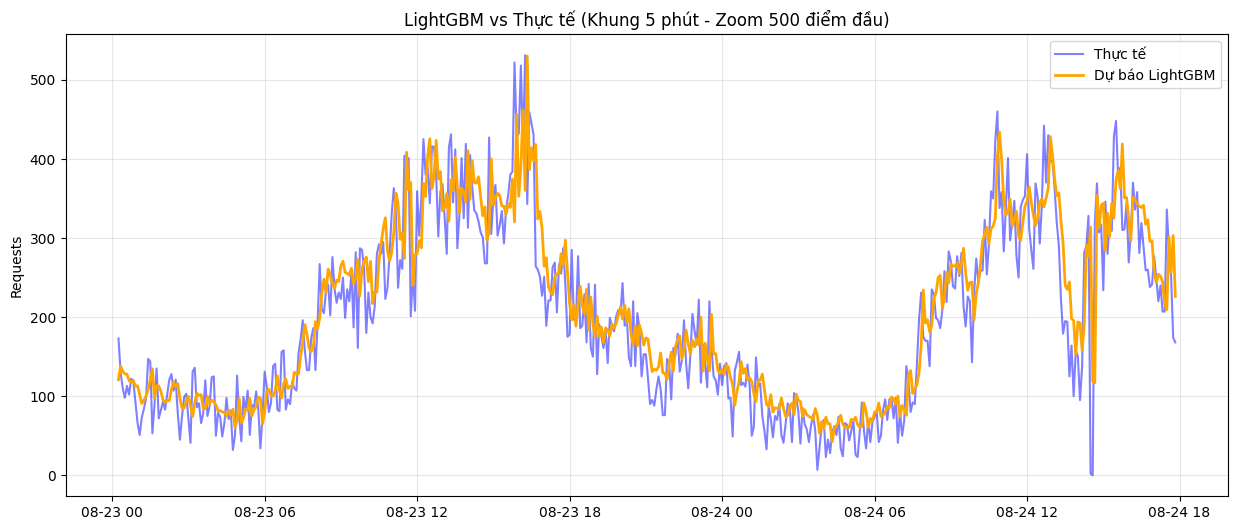

In [ ]:
# --- CELL 3 (5m): ĐÁNH GIÁ KẾT QUẢ (FULL 4 CHỈ SỐ) ---
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# 1. Dự báo
preds_5m = model_5m.predict(X_test_5m)

# 2. Tính toán đủ 4 chỉ số
mae = mean_absolute_error(y_test_5m, preds_5m)
mse = mean_squared_error(y_test_5m, preds_5m)   # <--- Bổ sung MSE
rmse = np.sqrt(mse)

mask = y_test_5m > 0
mape = np.mean(np.abs((y_test_5m[mask] - preds_5m[mask]) / y_test_5m[mask])) * 100

print(f"--- KẾT QUẢ LIGHTGBM (KHUNG 5 PHÚT) ---")
print(f"1. MAE:  {mae:.2f}")   # <--- Đã có
print(f"2. MSE:  {mse:.2f}")   # <--- Đã có
print(f"3. RMSE: {rmse:.2f}")
print(f"4. MAPE: {mape:.2f}%")
print(f"5. Thời gian: {time_5m:.2f}s")

# 3. Vẽ biểu đồ (Zoom 500 điểm đầu)
plt.figure(figsize=(15, 6))
limit = 500
plt.plot(y_test_5m.index[:limit], y_test_5m[:limit], label='Thực tế', color='blue', alpha=0.5)
plt.plot(y_test_5m.index[:limit], preds_5m[:limit], label='Dự báo LightGBM', color='orange', linewidth=2)
plt.title(f'LightGBM vs Thực tế (Khung 5 phút - Zoom {limit} điểm đầu)')
plt.ylabel('Requests')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()